In [1]:
import os
import csv
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, Binarizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 2 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

In [3]:
conf = create_spark_configuration()

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

:: loading settings :: url = jar:file:/opt/spark-3.5.2-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/user1/.ivy2/cache
The jars for the packages stored in: /home/user1/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a37e9bd5-9f7a-456c-ae89-3ac0d079b5b8;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 in central
:: resolution report :: resolve 584ms :: artifacts dl 24ms
	:: modules in use:
	org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spa

In [5]:
database_name = "lopin_database2"

In [6]:
spark.catalog.setCurrentDatabase(database_name)

In [18]:
df = spark.table("sobd_lab1_processed_table")

In [8]:
df.show()

+----------+--------------------+----------+------+------+-----------+
|product_id|       category_code|     brand| price|amount|PrefHalfDay|
+----------+--------------------+----------+------+------+-----------+
|   1002666|electronics.smart...|     honor|231.64|   417|          2|
|   1003023|electronics.smart...|       htc|126.13|     8|          2|
|   1003051|electronics.smart...|   samsung|599.66|   155|          2|
|   1003079|electronics.smart...|    huawei|180.16|    22|          1|
|   1003112|electronics.smart...|      sony|141.99|   706|          2|
|   1003159|electronics.smart...|      sony|123.56|    60|          2|
|   1003333|electronics.smart...|     apple|617.49|    44|          2|
|   1003372|electronics.smart...|      sony|411.31|   136|          2|
|   1003610|electronics.smart...|     meizu| 118.9|    50|          2|
|   1003715|electronics.smart...|   samsung| 818.3|    13|          1|
|   1003723|electronics.smart...|   tp-link|128.45|     1|          1|
|   10

In [9]:
df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- amount: long (nullable = true)
 |-- PrefHalfDay: string (nullable = true)



In [10]:
df.count()

160520

In [19]:
df = df.withColumn("PrefHalfDay",
                        col("PrefHalfDay").cast("Integer"))

In [20]:
df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- amount: long (nullable = true)
 |-- PrefHalfDay: integer (nullable = true)



In [24]:
train_df, test_df = df.randomSplit([0.8, 0.2])

In [25]:
print(f"Train dataset size: {train_df.count()}")
print(f"Test  dataset size: {test_df.count()}")

Train dataset size: 128381


Test  dataset size: 32139


In [13]:
categorical_features = ["category_code", "brand"]
binary_features = ["PrefHalfDay"]
numeric_features = ["amount"]

In [21]:
def create_pipeline(categorical_features: list[str], numeric_features: list[str],  
                    binary_features: list[str], label_col: str, max_iter: int) -> Pipeline:
    
    # Формируем названия колонок для преобразованных категориальных признаков
    indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
    
    # Выполняем преобразования данных
    string_indexer = StringIndexer(
        inputCols=categorical_features,
        outputCols=indexed_categorical_features,
        handleInvalid="keep"
    )
    vector_num_assembler = VectorAssembler(
        inputCols=numeric_features,
        outputCol="numeric_vector"
    )
    numeric_scaler = MinMaxScaler(
        inputCol="numeric_vector",
        outputCol="numeric_vector_scaled"
    )
    vector_all_assembler = VectorAssembler(
        inputCols=(indexed_categorical_features + binary_features + ["numeric_vector_scaled"]),
        outputCol="features"
    )

    # Создаем модель линейной регрессии
    linear_regression = LinearRegression(
        featuresCol="features",
        labelCol=label_col,
        predictionCol="prediction",
        standardization=False,
        maxIter=max_iter
    )

    # Создаем конвейер
    pipeline = Pipeline(stages=[
        string_indexer, vector_num_assembler,
        numeric_scaler, vector_all_assembler,
        linear_regression
    ])

    return pipeline

In [23]:
pipeline = create_pipeline(categorical_features=categorical_features,
                           numeric_features=numeric_features,
                           binary_features=binary_features,
                           label_col="price",
                           max_iter=15)

In [26]:
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].regParam, [0.01, 0.1, 1.0]) \
    .addGrid(pipeline.getStages()[-1].elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

In [27]:
cv_evaluator = RegressionEvaluator(labelCol="price",
                                   predictionCol="prediction",
                                   metricName="rmse")

In [28]:
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=cv_evaluator,
                                 numFolds=5)

In [29]:
cv_model = cross_validator.fit(train_df)

25/01/18 02:18:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/18 02:18:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [30]:
def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel.

    Args:
        cv_model (CrossValidatorModel): Объект CrossValidatorModel, 
            содержащий лучшую модель.

    Returns:
        Dict[str, float]: Параметры лучшей модели.
    """
    best_model = cv_model.bestModel
    best_params = {
        "regParam": best_model.stages[-1].getRegParam(),
        "elasticNetParam": best_model.stages[-1].getElasticNetParam(),
        "maxIter": best_model.stages[-1].getMaxIter()
    }
    return best_params

In [31]:
for key, value in get_best_model_params(cv_model=cv_model).items():
    print(f"{key}: {value}")

regParam: 0.01
elasticNetParam: 0.0
maxIter: 15


In [32]:
def plot_training_summary(cv_model: DataFrame) -> None:
    """
    Отображает графики зависимости значения ошибки от номера итерации на
    обучающей выборке, а также значения метрик RMSE и R^2.

    Args:
        cv_model (DataFrame): Обученная модель с использованием кросс-валидации.
    """
    # Получаем лучшую модель
    best_model = cv_model.bestModel

    # Получаем информацию о процессе обучения
    training_summary = best_model.stages[-1].summary

    # Получаем значения ошибки для каждой итерации
    objective_history = training_summary.objectiveHistory

    # Строим график зависимости значения ошибки от номера итерации
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(objective_history)), 
                 y=objective_history, 
                 marker='o')
    plt.xlabel('Итерация')
    plt.ylabel('Ошибка')
    plt.title("Зависимость значения функции ошибки от номера итерации")

    # Получаем значения метрик
    rmse = training_summary.rootMeanSquaredError
    r2 = training_summary.r2

    # Добавляем значения метрик на график
    plt.text(0.95, 0.95, f"RMSE: {rmse:.2f}\nR^2: {r2:.2f}",
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(facecolor='white', alpha=0.8), zorder=5)
    plt.grid()

    plt.show()

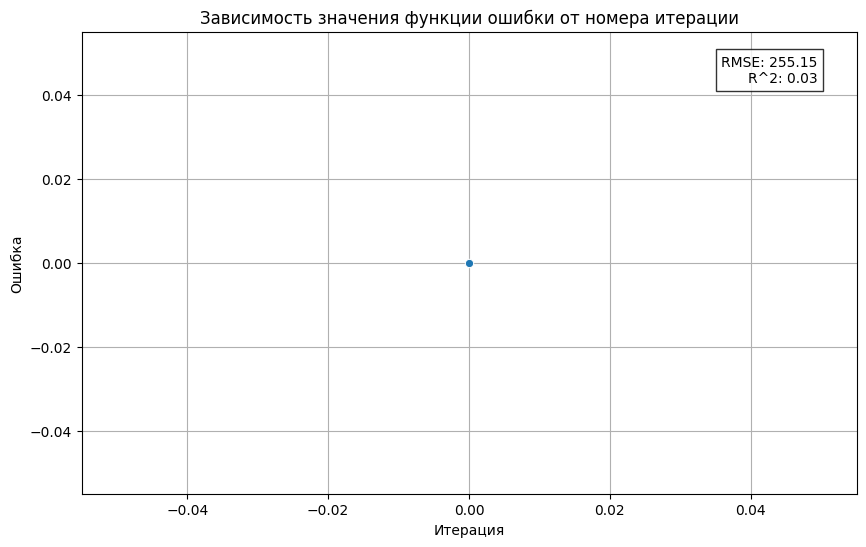

In [33]:
plot_training_summary(cv_model)

In [34]:
# Получаем датасет предсказаний
test_df_predictions = cv_model.transform(test_df)

# Извлекаем список колонок, устанавливаем цену на последнее место
right_columns_order = test_df_predictions.columns
right_columns_order.remove("price")
right_columns_order.append("price")

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)
test_df_predictions.show()

+----------+--------------------+-------+------+-----------+-------------------+-----------+--------------+---------------------+--------------------+------------------+-------+
|product_id|       category_code|  brand|amount|PrefHalfDay|category_code_index|brand_index|numeric_vector|numeric_vector_scaled|            features|        prediction|  price|
+----------+--------------------+-------+------+-----------+-------------------+-----------+--------------+---------------------+--------------------+------------------+-------+
|   1002328|electronics.smart...|     lg|     2|          1|               32.0|       52.0|         [2.0]| [0.00100200400801...|[32.0,52.0,1.0,0....|172.30527984113334|  25.71|
|   1002415|electronics.smart...|   sony|   161|          2|               32.0|       14.0|       [161.0]| [0.16032064128256...|[32.0,14.0,2.0,0....|207.16741037373612| 293.11|
|   1002662|electronics.smart...| xiaomi|   543|          2|               32.0|       21.0|       [543.0]| [0

In [35]:
def evaluate_model(data: DataFrame, metric_name: str) -> float:
    """
    Оценивает модель с использованием указанной метрики.

    Args:
        data (DataFrame): DataFrame, содержащий предсказания и фактические метки.
        metric_name (str): Название метрики для оценки (например, "rmse", "r2").

    Returns:
        float: Значение указанной метрики.
    """
    evaluator = RegressionEvaluator(labelCol="price", 
                                    predictionCol="prediction", 
                                    metricName=metric_name)
    metric_value = evaluator.evaluate(data)
    return metric_value

In [36]:
test_rmse = evaluate_model(test_df_predictions, "rmse")
test_r2 = evaluate_model(test_df_predictions, "r2")

print(f"RMSE on test data: {test_rmse:.2f}")
print(f"R^2 on test data: {test_r2:.2f}")

RMSE on test data: 262.01
R^2 on test data: 0.03
